<a href="https://colab.research.google.com/github/Approach-Analytics/Emotion-Classifier/blob/main/Train_Anger_Twitter_May10%2C2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training on Twitter Data - first try Fear 

Dataset 1.6 million english tweets Kaggle. Fear

In [1]:
#Need pip install tensorflow with...Jupyter Notebook

!pip install nlp
#!pip install tensorflow
!pip install h5py


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Install dependencies... 

In [2]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import pickle

In [3]:
#Dec 7, 2022: Not sure what this piece of code is used for... 

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Setting column options

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 100)

#Supressing the scientific notation 

pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Importing the Training Dataset 

In [5]:
# Load the Drive helper and mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Exporting the anger dataset 

path = "/content/drive/MyDrive/Sean/Emoclass/Emotion datasets/Anger_Twit_Kaggle_100K_May10,2023.csv"
df = pd.read_csv(path)

In [7]:
df.shape

(99997, 6)

In [8]:
df.columns 

Index(['text', 'emotion1', 'emotion2', 'num_words', 'treatment', 'new_word_length'], dtype='object')

In [9]:
df.head(100)

,text,emotion1,emotion2,num_words,treatment,new_word_length
0,"Ive studied lots in politics, but I specialize...",frustrated,frustrated,21,Nothing,21
1,I KNOW lmao i was mad dissapointed,mad,angry,7,Nothing,7
2,is aggravated and needs to get some sleep soon...,aggravated,agitated,25,Nothing,25
3,Is wondering why &quot; :O&quot; is an angry f...,angry,angry,11,Nothing,11
4,watched the first 3 episodes of Mad Men last n...,mad,angry,19,Nothing,19
...,...,...,...,...,...,...
95,really upset that I forgot my headphones today...,upset,agitated,8,Nothing,8
96,am having a day where i am being continuously ...,frustrated,frustrated,12,Nothing,12
97,"its mad and random, but you need to twitter, y...",mad,angry,24,Nothing,24
98,thinks her mother is mad Confirmed he he. Meg ...,mad,angry,17,Nothing,17


In [10]:
#df['emotion1'].value_counts()

In [11]:
df['emotion2'].value_counts()

angry         26737
calm          21778
annoyed       19051
agitated      17047
frustrated     8700
rage           6684
Name: emotion2, dtype: int64

#Setting the emotion axis 

In [12]:
#Anger Schema - May 4,2023  

emo_axis = {
    "rage": ['rage', 'raging', 'raged', 'fury', 'wrath', 'wrathful', 'furious', 'enraged', 'enraging', 'incensed', 'outraged'],
    "angry": ["angry", "anger", "angered", "mad", "maddening", "maddened"],
    "frustrated": ["frustration", "frustrate", "frustrated", "frustrating", "exasperated", "exasperating", "discontented", "vexed", "vexing", "bothered", "bothersome"],
    "agitated": ["agitated", "agitating", "agitation", "aggravated", "aggravation", "aggravating", "upset", 'upsetting', 'irritate', 'irritating', 'irritable', 'irritated'],
    "annoyed": ["annoying", "annoy", "annoyed", "pestered", "pestering", "pester", "troubled", "troubling", "disturbed", "disturbing", "harassed", "harassing", "nagged", "nagging"],
    "calm": ["calm", "peaceful", "serene", "serenity", "relax", "relaxing", "relaxed"]
}    
    

In [13]:
#Relabelling a column... if needed... 

df.rename(columns={"emotion2": "label"},inplace =True)

In [14]:
#Checking to see if classes are balanced or not...

df['label'].value_counts()

angry         26737
calm          21778
annoyed       19051
agitated      17047
frustrated     8700
rage           6684
Name: label, dtype: int64

#Counting Vocab Size and word length 

In [15]:
#Function to count word length...

def count_words(text):
    return len(text.split())

In [16]:
#Applying word length function

#Applying the function to count words... 

df['num_words'] = df['text'].apply(count_words)

In [17]:
#Identify maximum number of words... 

df['num_words'].describe()

count   99997.000
mean       12.613
std         6.823
min         1.000
25%         7.000
50%        12.000
75%        17.000
max        50.000
Name: num_words, dtype: float64

In [18]:
from collections import Counter

# Define a function to split text into words
def split_text(text):
    return text.split()

# Split the text in the 'text' column and count the occurrences of each word
word_counter = Counter()
for text in df['text']:
    words = split_text(text)
    word_counter.update(words)

# Calculate the vocabulary size
vocab_size = len(word_counter)

print(f"The vocabulary size is: {vocab_size}")


The vocabulary size is: 30663


#Removing key emotion words 

In [19]:
#check the right label is used...

#df['emotion1'].value_counts()

In [20]:
#Generate all the unique emotion words that then get replaced... 

a = df['emotion1'].unique().tolist()

#The list a is our list of variable responses from the dataset... 
keyword = "emotions"
words = a
for j in words: 
  df['text'] = df['text'].str.replace(j,keyword)

#Splitting into train, validate and test 

In [21]:
#This outputs 3 different dataframes... originally 0.6 and 0.8

train, validate, test = np.split(df.sample(frac=1, random_state=42),
                       [int(.8*len(df)), int(.9*len(df))])

#Preparing Labels 

In [22]:
#Converting the pandas dataframe into a list of labels... 
#We may consider puting this into a function... 

trainlabel=train['label'].tolist()
vallabel=validate['label'].tolist()
testlabel=test['label'].tolist()

In [23]:
#Creating the classes variable... with new emotion classifier..
# loneliness_axis

classes = list(emo_axis.keys())


In [24]:
# Map each class to a unique integer
classes_to_index = dict((c, i) for i, c in enumerate(classes))

# Map each integer back to its corresponding class
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [25]:
#Creating a lambda function...called "names_to_ids"

names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [26]:
#Applying the names_to_ids functions to the labels

train_labels = names_to_ids(trainlabel)
val_labels = names_to_ids(vallabel)
test_labels = names_to_ids(testlabel)

#Testing out the labels...
print(train_labels[10])

4


#Training and Tokenizing Tweets

Let's just use Keras' tokenizer... 

In [27]:
#Converting the different pandas dataframes into a list of text fields...
#Choice of variables: truncated_text, text_minus1, 'filtered_text',''filtered_text_minus1'

traintext=train['text'].tolist()
valtext=validate['text'].tolist()
testtext=test['text'].tolist()

In [28]:
#Importing the tokenizer...
#Input into the tokenizer is a list

from tensorflow.keras.preprocessing.text import Tokenizer

In [29]:
#Input into the tokenizer is a list

tokenizer = Tokenizer(num_words=30663, oov_token='<UNK>')

#I think that this is the missing piece...I'm not really sure what it does...  

tokenizer.fit_on_texts(traintext)
tokenizer.fit_on_texts(valtext)
tokenizer.fit_on_texts(testtext)

#Testing the tokenization... 

#print(tokenizer.texts_to_sequences([tweets[10]]))

#Tokenizing and Padding Sequences

Pay attention to provenance of tokenizer...

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [31]:
#Creating a function that tokenizes and pads the sequences...
#Max word length is 65...

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [32]:
#Applying the function to tokenize and pad... to all test,validate and test
#Syntax: val_sequences = get_sequences(tokenizer, val_tweets)

train_sequences = get_sequences(tokenizer, traintext)
val_sequence = get_sequences(tokenizer,valtext)
test_sequence = get_sequences(tokenizer,testtext)


#Configuring and Evaluating the Model 

##Attention Layer 

In [33]:
#Add the attention Layer 

from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)


##Specify the model

In [34]:
#Specify the model

#Specifying the model - words: 27026

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(30663, 200, input_length=50),
    tf.keras.layers.Conv1D(200, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True)),
    Attention(),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           6132600   
                                                                 
 conv1d (Conv1D)             (None, 46, 200)           200200    
                                                                 
 bidirectional (Bidirectiona  (None, 46, 400)          641600    
 l)                                                              
                                                                 
 attention (Attention)       (None, 400)               446       
                                                                 
 dense (Dense)               (None, 6)                 2406      
                                                                 
Total params: 6,977,252
Trainable params: 6,977,252
Non-trainable params: 0
______________________________________________

##Running the model 

In [35]:
#Most up to date architecture: April 15, 2023 -> Fa

#Having the callbacks option on means that the model stops once you are like over-generalizing... 
#Let's leave the callback option on for now...


h = model.fit(
    train_sequences, train_labels,
    validation_data=(val_sequence, val_labels),
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
   ]
)

Epoch 1/5
2500/2500 [==============================] - 74s 26ms/step - loss: 0.7869 - accuracy: 0.7081 - val_loss: 0.4228 - val_accuracy: 0.8528
Epoch 2/5
2500/2500 [==============================] - 35s 14ms/step - loss: 0.2981 - accuracy: 0.8946 - val_loss: 0.2994 - val_accuracy: 0.8954
Epoch 3/5
2500/2500 [==============================] - 32s 13ms/step - loss: 0.1989 - accuracy: 0.9286 - val_loss: 0.2496 - val_accuracy: 0.9171
Epoch 4/5
2500/2500 [==============================] - 32s 13ms/step - loss: 0.1512 - accuracy: 0.9459 - val_loss: 0.2341 - val_accuracy: 0.9252
Epoch 5/5
2500/2500 [==============================] - 34s 13ms/step - loss: 0.1238 - accuracy: 0.9557 - val_loss: 0.2375 - val_accuracy: 0.9252


#Evaluating the model 

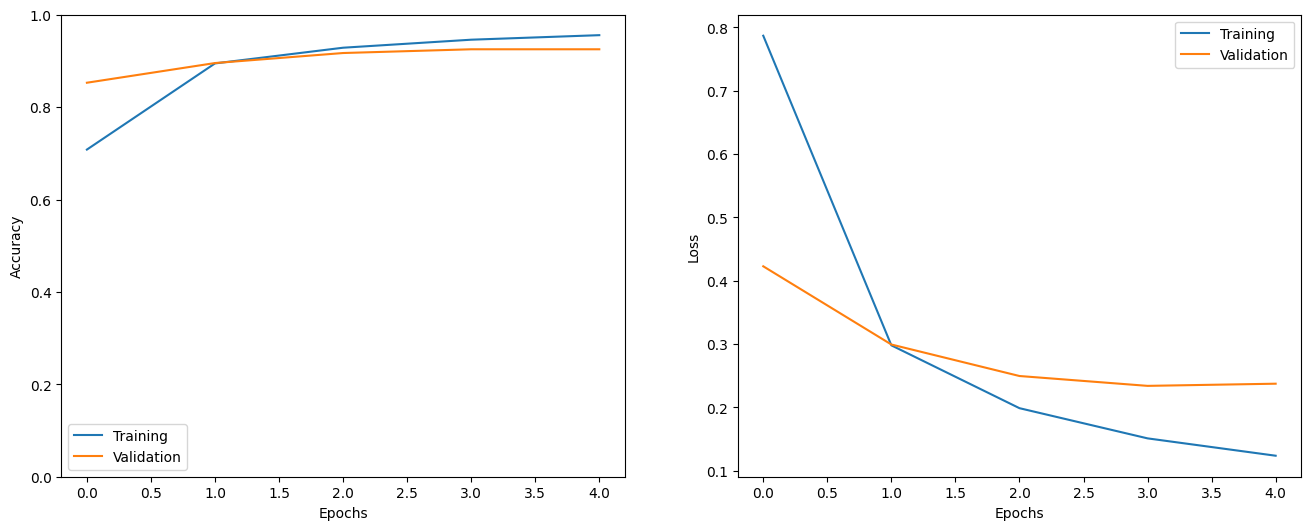

In [36]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [37]:
#Running the model on the test sequence and test labels... 

eval = model.evaluate(test_sequence, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 0.2296 - accuracy: 0.9306


In [38]:
#preds = model.predict_classes(test_sequence)
preds=model.predict(test_sequence) 
classes_x=np.argmax(preds,axis=1)
preds.shape, test_labels.shape

313/313 [==============================] - 3s 6ms/step


((10000, 6), (10000,))

##Error Analysis 

In [39]:
#Dumb luck metric 

counts = df['label'].value_counts()
dumb_luck = max(counts) / sum(counts)

dumb_luck

0.2673780213406402

In [40]:
#Creating an inference dataframe 

inf_df=pd.DataFrame({
    'data':testtext,
    "labels_predicted": classes_x                    
})
inf_df["labels_predicted_marked"]=inf_df['labels_predicted'].apply(lambda x: index_to_classes[x])
inf_df["actual_labels"]=testlabel

#Creating the labels index datastructure...

inf_df["actual_label_index"]=inf_df['actual_labels'].apply(lambda x: classes_to_index[x])

In [41]:
#Checking the inf_df shape...

inf_df.shape

(10000, 5)

In [42]:
#Making the correct prediction 

inf_df['correct_pred']=0 # first assigning all to 0.
inf_df.loc[(inf_df['labels_predicted']==inf_df['actual_label_index']),'correct_pred']=1 # labelling 1 if the prediction is right.

In [43]:
# magnitutde of error
inf_df['error_magnitude']=abs(inf_df['labels_predicted']-inf_df['actual_label_index'])

Text(0, 0.5, 'Frequency')

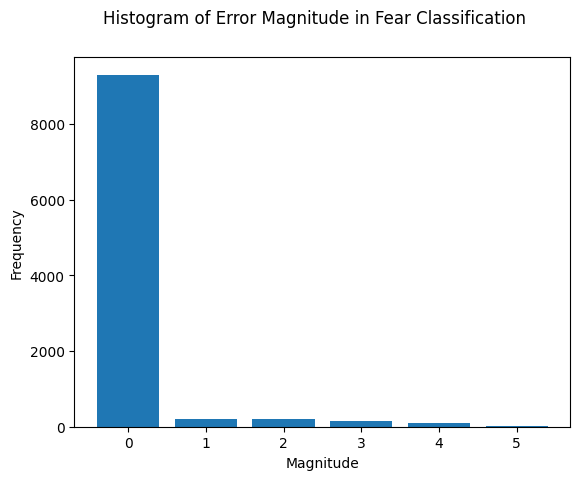

In [44]:
# Count the frequency of each class in the error_magnitude column
counts = inf_df['error_magnitude'].value_counts()

# Create a histogram with one bar for each class
plt.bar(counts.index, counts.values)

# Set the title and axis labels
plt.suptitle('Histogram of Error Magnitude in Fear Classification')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')

#Saving the model, tokenizer and eval dataset

In [47]:
from keras.models import load_model

# Make sure you provide the full file path, including the .h5 extension

model.save('/content/drive/MyDrive/Sean/Emoclass/Model_Anger_twit_15Kori_aug100K_May5,2023.h5')

In [46]:
#Saving the tokenizer...

from tensorflow.keras.preprocessing.text import Tokenizer

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
